# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

2023-04-02 22:48:49.587155: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-02 22:48:49.589411: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 22:48:49.636467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 22:48:49.637214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 22:48:50.348344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

42

# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

container = "all-sites-data"
blob_name = "hybrid-2010-2015-raw-v0.parquet"
local_file = tmp_dir + os.sep + blob_name

In [5]:
# Download full data
data_df = get_raw_datasets(container, blob_name)
data_df.rename(columns={"rfr_pred_gpp": "estimated_gpp"}, inplace=True)

Data size: (4862712, 52)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month', 'rfr_pred_gpp'],
      dtype='object')
NA count: 0


# Eval Model

In [5]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/treeft_5YrTrain_1WkEncode_RFRGPP_slim_LrE-4_230402_0819/" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/treeft_5YrTrain_1WkEncode_RFRGPP_slim_LrE-4_230402_0819/version_0/checkpoints/epoch=7-step=43920.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
ENCODER_LEN = 24*7

# Create dataloaders for model
batch_size = 256
cpu_count = os.cpu_count()

# Define tsdataset
def setup_tsdataset_rfr_gpp_slim(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=['estimated_gpp'],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


In [7]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
print(f"Validation size: {val_df.shape}")
_, validation, _ = setup_tsdataset_rfr_gpp_slim(train_df, val_df, None, ENCODER_LEN)
del train_df
gc.collect()

Validation size: (1056072, 52)


29

## Eval 5 Years of Validation Data

In [8]:
# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=os.cpu_count())

start = default_timer()
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_raw_predictions = best_tft.predict(val_dataloader, mode="raw", show_progress_bar=True)
print(f"Val eval time: {default_timer() - start}")

Predict: 100%|██████████| 4109/4109 [38:25<00:00,  1.78 batches/s]

Val eval time: 2331.522395952


In [9]:
# save eval results - also we can resume tuning at a later point in time
with open(exp_model_dir + os.sep + "val_actuals.pkl", "wb") as fout:
    pickle.dump(val_actuals, fout)
    
with open(exp_model_dir + os.sep + "val_prediction.pkl", "wb") as fout:
    pickle.dump(val_raw_predictions['prediction'], fout)

In [10]:
# load eval results - also we can resume eval at a later point in time
with open(exp_model_dir + os.sep + "val_actuals.pkl", "rb") as fin:
    val_acutals = pickle.load(fin)

with open(exp_model_dir + os.sep + "val_prediction.pkl", "rb") as fin:
    val_q_predictions = pickle.load(fin)

val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
val_p90 = val_q_predictions[:, :,5] # p90
#del val_q_predictions
    
# Unmasked evaltaion
eval_metric = get_eval_metrics(val_actuals, val_predictions, None, val_p90)
print(f"Unmasked Val eval evaluation: {eval_metric}")

# Masked evlationa
start = default_timer()
mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
masked_eval_metric = get_eval_metrics(val_actuals, val_predictions, mask, val_p90)
eval_time = default_timer() - start
print(f"Masked Val eval time: {eval_time}")
print(f"Masked Val eval evaluation: {masked_eval_metric}")

Unmasked Val eval evaluation: {'rmse': 3.711132764816284, 'mae': 2.0367965698242188, 'nse': 0.7287424802780151, 'r2': 0.7287425136678634, 'p50_loss': 0.5004878044128418, 'p90_loss': 0.28500664234161377}
Masked Val eval time: 49.41323187299986
Masked Val eval evaluation: {'rmse': 3.7986040115356445, 'mae': 2.091487407684326, 'nse': 0.7296391725540161, 'r2': 0.7296391788688865, 'p50_loss': 0.5113350749015808, 'p90_loss': 0.2916163206100464}


# Model Interpreation

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x625 with 1 Axes>,
 'decoder_variables': <Figure size 700x550 with 1 Axes>}

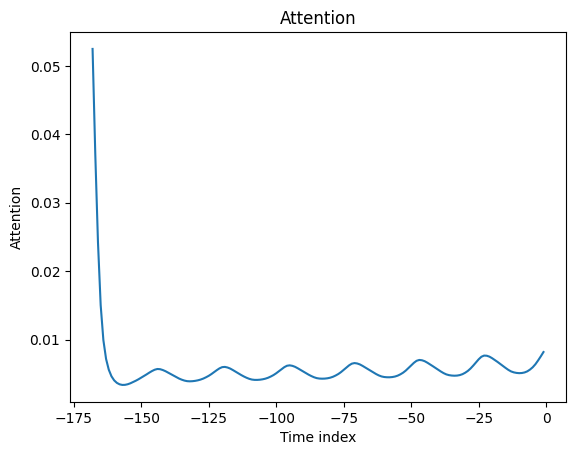

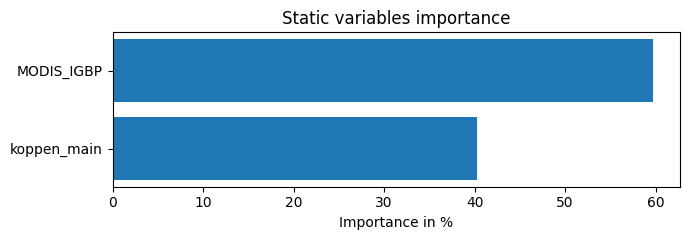

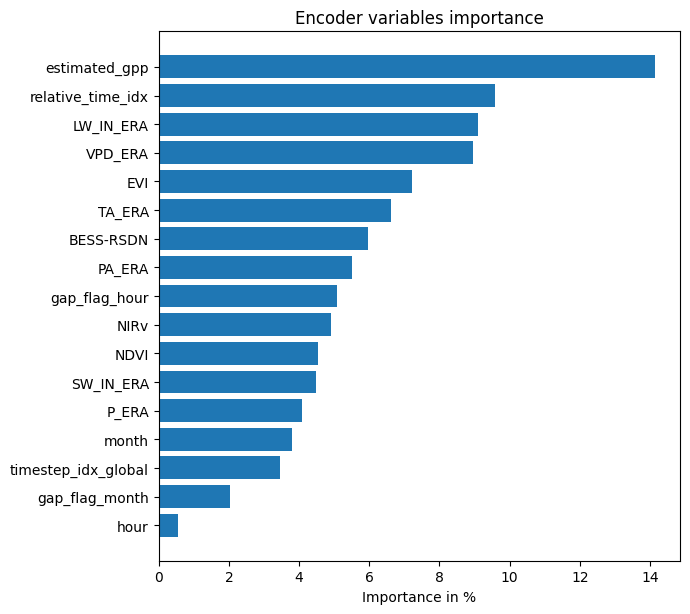

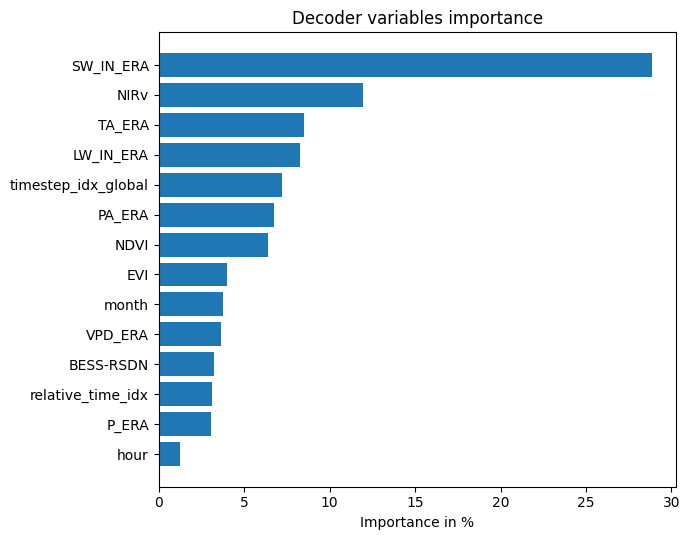

In [11]:
interpretation = best_tft.interpret_output(val_raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [12]:
with open(exp_model_dir + os.sep + "val_interpretation.pkl", "wb") as fout:
    pickle.dump(interpretation, fout)

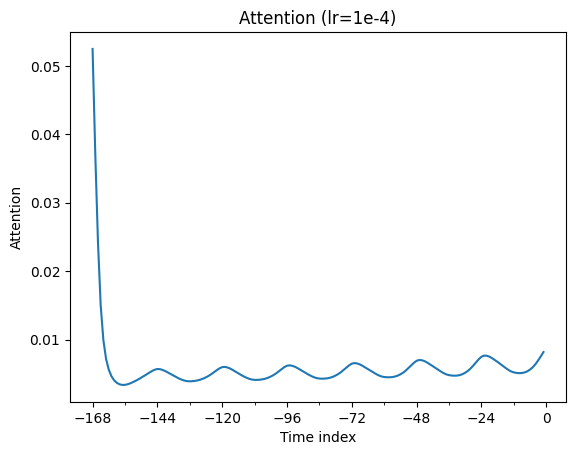

In [8]:
with open(exp_model_dir + os.sep + "val_interpretation.pkl", "rb") as fin:
    interpretation = pickle.load(fin)

def custom_attention_plot(interpretation, max_encoder_length):
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(
            np.arange(-max_encoder_length, attention.size(0) - max_encoder_length), attention
        )
        
        # Set tick
        major_ticks = np.arange(-max_encoder_length, 1, 24) # every 24hr
        minor_ticks = np.arange(-max_encoder_length, 1, 12) # every 12HR
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        
        # Set Label
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention (lr=1e-4)")
        figs["attention"] = fig

custom_attention_plot(interpretation, ENCODER_LEN)